In [1]:
##################################################################
############# FORECASTING DAY AHEAD ENERGY PRICE ################
################################################################

In [20]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
#import timeseries as ts
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from sklearn.externals import joblib
import seaborn as sns

In [21]:
data = pd.read_csv("combined_energy.csv", parse_dates=True)

In [22]:
from datetime import datetime as dt
data["SETTLEMENTDATE"] = pd.to_datetime(data["SETTLEMENTDATE"])

# Seperating data for each region
dataSA = data[data["REGIONID"] == "SA1"]

# Setting Index to Date
dataSA = dataSA[["SETTLEMENTDATE","RRP5min"]]
dataSA.index = dataSA["SETTLEMENTDATE"]
dataSA.drop(columns="SETTLEMENTDATE", inplace=True)

In [23]:
dataSA.loc["2008-02-25"]

,RRP5min
SETTLEMENTDATE,


In [5]:
# Convert data into hourly time frame
dataSA = dataSA.resample('H').sum()

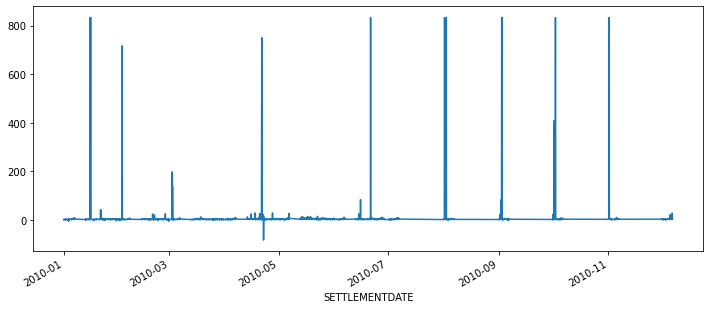

In [24]:
# plot the price full price data set
ax = dataSA.loc['2010'].plot(figsize=(12, 5), legend=False)

In [7]:
# keep raw data of the test set for model evaluation
test_raw = dataSA['2010']

def replace_outliers(data, column, tolerance):

    """Replace outliers out of 75% + tolerance * IQR or 25% - tolerance * IQR by these thresholds"""
    
    tol = tolerance
    data_prep = data.copy(deep=True)
    
    # calculate quantiles and inter-quantile range of the data
    q75 = data_prep[column].quantile(.75)
    q25 = data_prep[column].quantile(.25)
    IQR = q75 - q25

    # values larger (smaller) than q75 (q25) plus 'tol' times IQR get replaced by that value
    data_prep[column] = data_prep[column].apply(lambda x: q75 + tol * IQR if (x > q75 + tol * IQR) else x)
    data_prep[column] = data_prep[column].apply(lambda x: q25 - tol * IQR if (x < q75 - tol * IQR) else x)
    
    return data_prep

In [25]:
# replace outliers by outlier threshold
dataSA = replace_outliers(dataSA, 'RRP5min', 3)

In [26]:
# Scaling the RRP between 0 and 1 as required by the NN
scaler = MinMaxScaler()
dataSA["RRP5min"] = scaler.fit_transform(dataSA["RRP5min"].values.reshape(-1,1))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8da79288e0>],
      dtype=object)

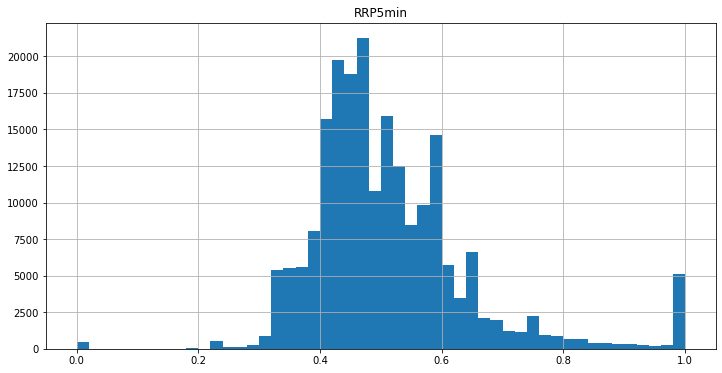

In [27]:
f, ax = plt.subplots(figsize=(12, 6))
dataSA.hist(bins=50, ax=ax)

In [11]:
dataSA

,RRP5min
SETTLEMENTDATE,
2008-01-07 00:00:00,0.556747
2008-01-07 01:00:00,0.551866
2008-01-07 02:00:00,0.511425
2008-01-07 03:00:00,0.490760
2008-01-07 04:00:00,0.488235
...,...
2010-12-06 19:00:00,0.623703
2010-12-06 20:00:00,0.796981
2010-12-06 21:00:00,0.953477


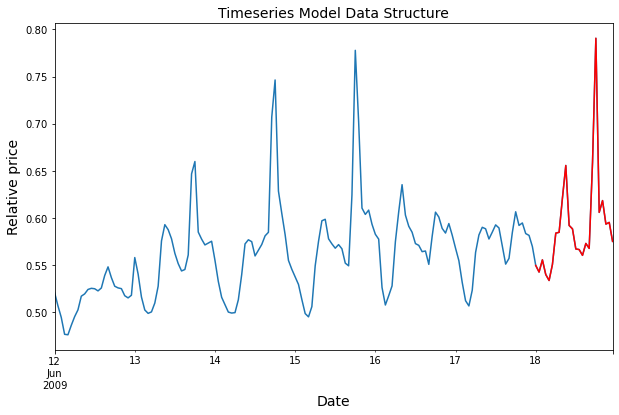

In [12]:
feature_data = dataSA.loc['2009-06-12':'2009-06-18', 'RRP5min']
feature_data.columns = ['input data']
label_data = dataSA.loc['2009-06-18', 'RRP5min']
label_data.columns = ['data to predict']
f, ax = plt.subplots(figsize=(10, 6))
feature_data.plot(ax=ax)
label_data.plot(ax=ax, color='red')
ax.set_ylabel('Relative price', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Timeseries Model Data Structure', fontsize=14);

In [13]:
# include time lags of timeseries data for 1 week = 7 * 24h = 168h
lags = 168
for i in range(1,lags+1):
    dataSA["l_{}".format(i)] = dataSA["RRP5min"].shift(i)

In [28]:
# Drop NANS
dataSA.dropna(inplace=True)
dataSA.head(5)

,RRP5min
SETTLEMENTDATE,
2008-01-07 00:00:00,0.510286
2008-01-07 00:05:00,0.509648
2008-01-07 00:10:00,0.509648
2008-01-07 00:15:00,0.509648
2008-01-07 00:20:00,0.509648


In [15]:
# create feature and label dataframes
prelim_features = dataSA.drop('RRP5min', axis=1)
prelim_labels = pd.DataFrame(dataSA['RRP5min'])


In [29]:
# format labels to 24 hour output range
for i in range(0, 24):
    prelim_labels['t_{}'.format(i)] = prelim_labels['RRP5min'].shift(-i)
prelim_labels.drop('RRP5min', axis=1, inplace=True)

# apply one-day discretization to the data
labels = prelim_labels[prelim_labels.index.hour == 0]
features = prelim_features[prelim_features.index.hour == 0]

features_train = features[:'2009']
features_test = features['2010':]
labels_train = labels[:'2009']

samples_train = len(features_train)
samples_test = len(features_test)
timesteps = 168

# convert pandas data frames to numpy ndarrays
features_train = features_train.to_numpy().reshape(samples_train, timesteps, 1)
features_test = features_test.to_numpy().reshape(samples_test, timesteps, 1)
labels_train = labels_train.to_numpy()

# check for correct data shape
features_train.shape, labels_train.shape

KeyError: 'RRP5min'

In [19]:
from keras.models import Model, load_model
from keras.layers import Input, Add
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2
from tensorflow.keras.layers import Dropout as dp

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

In [30]:
# split into training and validation data
X_train, X_valid, y_train, y_valid = train_test_split(features_train, labels_train, test_size=0.2, random_state=7)

NameError: name 'train_test_split' is not defined

In [31]:
def train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, X_test, y_test, test_index, scaler, 
                           batch_size, epochs, filename='model.hdf5', verbose=0):
    
    """Fit model to training data. Use best performant on validation data to predict for the test set. 
    Evaluate on the test set and return results as dataframes"""
    
    # train model, save best keep best performer on validation set
    checkpoint = ModelCheckpoint('./models/' + filename, save_best_only=True)
    hist = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[checkpoint], 
                     verbose=verbose, batch_size=batch_size, epochs=epochs)
    
    # load best model
    best = load_model('./models/' + filename)

    # predict for test set
    pred = best.predict(X_test)
    
    
    # transform back to original data scale
    pred = scaler.inverse_transform(pred.flatten().reshape(-1, 1))
    results = pd.DataFrame({'prediction':pred.flatten(), 'true values':y_test}, index=test_index)
    
    return results, hist

In [33]:
# design the neural network architecture with the keras functional API
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Conv1D(64, kernel_size=24, strides=24, padding='valid')(input_layer)
x = LSTM(50, recurrent_activation='relu')(x)
#x = LSTM(50, recurrent_activation='relu')(x)
#x = dp(0.2)(x) # NO ONE NEURON TO AFFECT MUCH. COMMENT THIS
output_layer = Dense(24)(x)
model = Model(inputs=[input_layer], outputs=[output_layer])
model.compile(loss='mse', optimizer='adam')
model.summary()

NameError: name 'Input' is not defined

In [35]:
###################### DESIGNING THE NN ###################
##########################################################

from keras.models import Model, load_model
from keras.layers.convolutional import Conv1D
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l1_l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import json

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising
rnn = Sequential()
# Adding Conv1D Layer
rnn.add(Conv1D(64, kernel_size=288, strides=288, padding='valid', input_shape=(X_train.shape[1],1)))
# Add LSTM layer 1st
rnn.add(LSTM(50, recurrent_activation='relu', return_sequences=True))
rnn.add(Dropout(0.1))
# Add LSTM layer 2nd
rnn.add(LSTM(50, recurrent_activation='relu'))
rnn.add(Dropout(0.1))
rnn.add(Dense(units=24))
rnn.compile(optimizer='adam', loss='mse')

NameError: name 'X_train' is not defined

In [48]:
# train the model and calculate the performance on the test set
results, hist = train_predict_evaluate(model, X_train, X_valid, y_train, y_valid, features_test,
                                       test_raw.to_numpy().flatten(), test_set.index, scaler, 100, 200, 
                                       'simple_neural_network.hdf5', verbose=1)

Epoch 1/200
6/6 [==============================] - 1s 110ms/step - loss: 0.2889 - val_loss: 0.2785
Epoch 2/200
6/6 [==============================] - 0s 33ms/step - loss: 0.2606 - val_loss: 0.2348
Epoch 3/200
6/6 [==============================] - 0s 52ms/step - loss: 0.2087 - val_loss: 0.1771
Epoch 4/200
6/6 [==============================] - 0s 34ms/step - loss: 0.1573 - val_loss: 0.1334
Epoch 5/200
6/6 [==============================] - 0s 29ms/step - loss: 0.1185 - val_loss: 0.1000
Epoch 6/200
6/6 [==============================] - 0s 49ms/step - loss: 0.0897 - val_loss: 0.0766
Epoch 7/200
6/6 [==============================] - 0s 39ms/step - loss: 0.0679 - val_loss: 0.0551
Epoch 8/200
6/6 [==============================] - 0s 25ms/step - loss: 0.0485 - val_loss: 0.0379
Epoch 9/200
6/6 [==============================] - 0s 33ms/step - loss: 0.0332 - val_loss: 0.0253
Epoch 10/200
6/6 [==============================] - 0s 42ms/step - loss: 0.0227 - val_loss: 0.0170
Epoch 11/200
6/6 [

Epoch 84/200
6/6 [==============================] - 0s 54ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 85/200
6/6 [==============================] - 0s 21ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 86/200
6/6 [==============================] - 0s 29ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 87/200
6/6 [==============================] - 0s 35ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 88/200
6/6 [==============================] - 0s 35ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 89/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0056 - val_loss: 0.0040
Epoch 90/200
6/6 [==============================] - 0s 20ms/step - loss: 0.0054 - val_loss: 0.0042
Epoch 91/200
6/6 [==============================] - 0s 22ms/step - loss: 0.0052 - val_loss: 0.0040
Epoch 92/200
6/6 [==============================] - 0s 19ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 93/200
6/6 [==============================] - 0s 30ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 94/2

6/6 [==============================] - 0s 18ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 167/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 168/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 169/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 0.0039
Epoch 170/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0050 - val_loss: 0.0037
Epoch 171/200
6/6 [==============================] - 0s 13ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 172/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 173/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 174/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 175/200
6/6 [==============================] - 0s 14ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 176/200


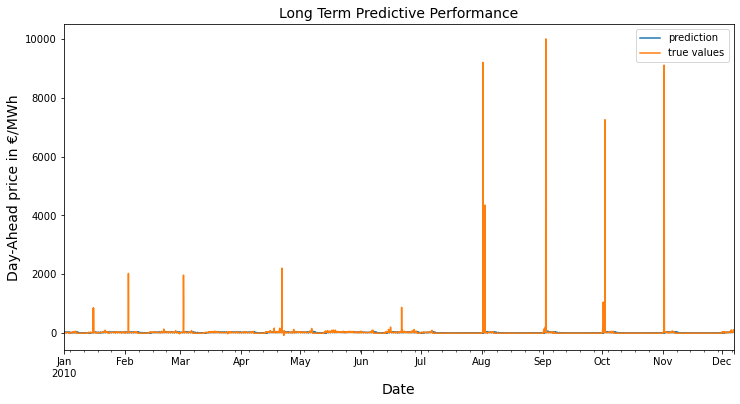

In [34]:
f, ax = plt.subplots(figsize=(12, 6))
results.plot(ax=ax)
ax.set_ylabel('Day-Ahead price in €/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Long Term Predictive Performance', fontsize=14);

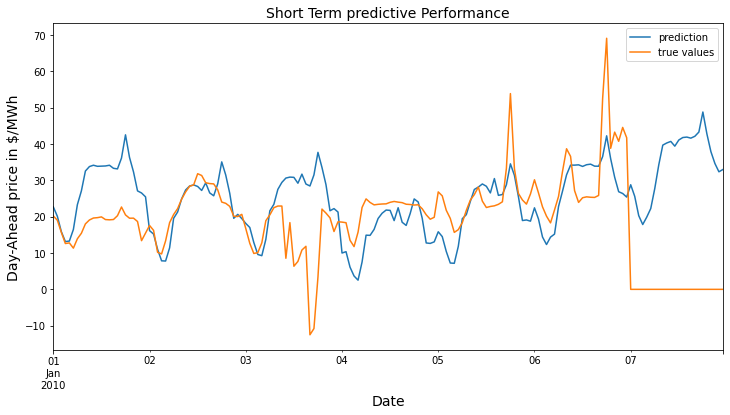

In [50]:
f, ax = plt.subplots(figsize=(12, 6))
results.loc['2010-01-01':'2010-01-7'].plot(ax=ax);
ax.set_ylabel('Day-Ahead price in $/MWh', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
ax.set_title('Short Term predictive Performance', fontsize=14);

In [37]:
results.head(100)

,prediction,true values
SETTLEMENTDATE,,
2010-01-01 00:00:00,24.287838,20.187360
2010-01-01 01:00:00,23.054758,19.032720
2010-01-01 02:00:00,17.142508,15.678975
2010-01-01 03:00:00,14.919151,12.610706
2010-01-01 04:00:00,15.074835,12.786080
...,...,...
2010-01-04 23:00:00,14.914762,19.836879
2010-01-05 00:00:00,16.788910,26.819425
2010-01-05 01:00:00,14.892385,25.734549


In [45]:
print('MAE: ', mean_absolute_error(y_pred=results['prediction'], y_true=results['true values']))

MAE:  23.547804467051368


In [19]:
features

,l_1,l_2,l_3,l_4,l_5,l_6,l_7,l_8,l_9,l_10,...,l_159,l_160,l_161,l_162,l_163,l_164,l_165,l_166,l_167,l_168
SETTLEMENTDATE,,,,,,,,,,,,,,,,,,,,,
2008-01-14,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,...,0.597893,0.610081,0.577235,0.541780,0.495068,0.488235,0.490760,0.511425,0.551866,0.556747
2008-01-15,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,...,0.587611,0.606456,0.593337,0.535024,0.484471,0.475265,0.478909,0.513229,0.543553,0.570596
2008-01-16,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,...,0.602356,0.602357,0.584861,0.556344,0.498565,0.485219,0.492620,0.512822,0.525699,0.536807
2008-01-17,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,...,0.600864,0.579152,0.525865,0.425692,0.484241,0.478351,0.475928,0.507804,0.525603,0.527287
2008-01-18,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,...,0.816467,0.804009,0.668883,0.606041,0.579989,0.537057,0.536891,0.574146,0.649950,0.633706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-12-02,0.459085,0.473946,0.493357,0.548527,0.559234,0.562089,0.558609,0.524978,0.567721,0.580140,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571
2010-12-03,0.544365,0.531871,0.522052,0.549186,0.561345,0.559436,0.560440,0.574855,0.577802,0.575749,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571
2010-12-04,0.497298,0.503418,0.508377,0.518181,0.521809,0.527757,0.540095,0.544911,0.539523,0.538765,...,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571,0.428571


In [ ]:
##################################
## Custom Function for plotting
#################################

def plot_chart(data, xlab='Time', ylab='Price ($)', title=None, legend=False):
    ax = data.plot(figsize=(12, 5), legend=legend)
    ax.set_ylabel(ylab, fontsize=14)
    ax.set_xlabel(xlab, fontsize=14)
    ax.set_title(title, fontsize=14);